In [1]:
import SimpleITK as sitk
from viz import *
from clinical_evaluation.registration_tools import preprocess, pipeline, metrics
from itkwidgets import view, compare, checkerboard

ModuleNotFoundError: No module named 'scipy'

In [2]:
pipeline = pipeline.EvaluationPipeline()

valid_folder = "/home/suraj/Repositories/data/NKI/valid"

In [3]:
# Load planning CT
CT = pipeline.load(f"{valid_folder}/21503950/CT/3/CT.nrrd")

# Load masks of interest
# bladder_mask = pipeline.load("/home/suraj/Repositories/data/cervix-eval/CT/21700691/0/BLADDER.nrrd")
# bowel_mask = pipeline.load("/home/suraj/Repositories/data/cervix-eval/CT/21700691/0/BOWELAREA.nrrd")

In [4]:
CT = pipeline.apply_body_mask(CT)

In [5]:
view(CT)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageSS3; pr…

In [6]:
# # Resample masks to image spacing
# bowel_mask = preprocess.resample_image_to_spacing(bowel_mask, CT.GetSpacing(), default_value=0, interpolator='nearest')
# bladder_mask = preprocess.resample_image_to_spacing(bladder_mask, CT.GetSpacing(), default_value=0, interpolator='nearest')

In [5]:
# Load first CBCT in the sequence of CBCTS
CBCT = pipeline.load(f"{valid_folder}/21503950/CBCT/X01.nrrd")
CBCT = preprocess.hu_correction(CBCT)
# CBCT = pipeline.apply_body_mask(CBCT, -700)

In [6]:
view(CBCT)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageSS3; pr…

In [7]:
# Custom cylinder mask code

# # Generate FOV mask cylinder based on thresholding + hole filling
fill_holes = sitk.VotingBinaryHoleFillingImageFilter()
fov_mask = fill_holes.Execute(CBCT!=-1024)
# sitk.WriteImage(fov_mask, "fov_mask.nrrd", True)

### SimpleElastix Registration Process


In [5]:
# Perform deformable registration
params = {
    "parameter_file": "/home/suraj/Repositories/clinical-evaluation/elastix_params/Par0032_bsplines.txt",
#     "target_mask": fov_mask
}

dpCT, elastixImageFilter = pipeline.deform(CT, CBCT, params, mode='Elastix')

RuntimeError: Exception thrown in SimpleITK ElastixImageFilter_Execute: /repos/Maastro/Prototyping/SimpleElastix/Code/Elastix/src/sitkElastixImageFilterImpl.cxx:259:
sitk::ERROR: 
itk::ExceptionObject (0x55a4822b4090)
Location: "unknown" 
File: /repos/Maastro/Prototyping/SimpleElastix/build/Elastix/Core/Main/elxElastixFilter.hxx
Line: 253
Description: itk::ERROR: ElastixFilter(0x55a48244a4e0): Internal elastix error: See elastix log (use LogToConsoleOn() or LogToFileOn()).



In [7]:
dpCT = sitk.Cast(dpCT, sitk.sitkInt16)

In [8]:
checkerboard(dpCT, CBCT)

In [9]:
compare(dpCT, CBCT)

AppLayout(children=(HBox(children=(Label(value='Link:'), Checkbox(value=False, description='cmap'), Checkbox(v…

In [13]:
# bladder_mask = sitk.Cast(sitk.Transformix(bladder_mask, elastixImageFilter.GetTransformParameterMap()), sitk.sitkInt8)

In [10]:
abs_diff_CBCT = metrics.get_abs_diff(CBCT, dpCT)

In [11]:
view(abs_diff_CBCT)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageSS3; pr…

In [12]:
metrics.get_statistics(abs_diff_CBCT)

----- REPORT --------
 Mean: 142.85788033732013 
             Max: 3146.0 
 Min: 0.0 
 Variance: 43459.36939207388


In [17]:
# dpCT = pipeline.deform(CT, sCT, None)
# dpCT = sitk.Cast(dpCT, sitk.sitkInt16)
abs_diff_sCT = metrics.get_abs_diff(sCT, dpCT)
metrics.get_statistics(abs_diff_sCT)

----- REPORT --------
 Mean: 68.50797682035777 
             Max: 2702.0 
 Min: 0.0 
 Variance: 18029.894181541007


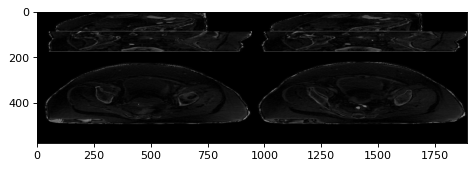

In [18]:
show_mid_slices(abs_diff_sCT)

In [19]:
sitk.WriteImage(CBCT, "CBCT1.nrrd", True)
sitk.WriteImage(dpCT, "dpCT1.nrrd", True)
sitk.WriteImage(CT, "pCT1.nrrd", True)
sitk.WriteImage(sCT, "sCT1.nrrd", True)
sitk.WriteImage(abs_diff_CBCT, "abs_diff_CBCT1.nrrd", True)
sitk.WriteImage(abs_diff_sCT, "abs_diff_sCT1.nrrd", True)
